In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from copy import deepcopy
from config import OPENAI_API_KEY
import openai
import os
from tqdm import tqdm
import json

In [2]:
# basic config
token_limit = 1500

In [3]:
input_file_path = '../data/raw_data/2018_1_medium.csv'
output_file_path = '../data/synthetic_data/2018_1_medium_4.csv'
df = pd.read_csv(input_file_path)
df.head(3)

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning
0,115849542,2018-01-01 00:00:00,ABC News,"Pope on 2018: forget life's useless baggage, w...","Pope on 2018: forget life's useless baggage, w...",Interested in Pope? Add Pope as an interest to...,Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER
1,59601230,2018-01-01 00:00:00,Chicago Tribune,"Trump welcomes new year with party, tweets",NaN,President Donald Trump bid farewell to 2017 wi...,Catherine Lucey,www.chicagotribune.com,http://www.chicagotribune.com/news/nationworld...,UNDEFINED
2,55136084,2018-01-01 00:00:00,Los Angeles Times,A 'monumental moment' for fully legal marijuan...,NaN,Will Senn has been waiting his whole life for ...,Patrick Mcgreevy,www.latimes.com,http://www.latimes.com/politics/la-pol-ca-pot-...,LEFT


In [4]:
def count_tokens_in_text(string: str, encoding_name: str) -> int:
    """
    This function calculates the number of tokens in a text string.
    Input: string (text from which the number of tokens need to be counted), encoding_name (encoding scheme to use)
    Output: num_tokens (number of tokens in the input string)
    """
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [5]:
# get the number of words in each body, as a new column
df['n_words'] = df['body'].str.split().str.len()
# get the number of tokens in each body, as a new column
df['n_tokens'] = df['body'].apply(lambda x: count_tokens_in_text(x, 'cl100k_base')) # cl100k_base is for gpt3.5 and gpt4
df.head(3)

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,n_words,n_tokens
0,115849542,2018-01-01 00:00:00,ABC News,"Pope on 2018: forget life's useless baggage, w...","Pope on 2018: forget life's useless baggage, w...",Interested in Pope? Add Pope as an interest to...,Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER,435,550
1,59601230,2018-01-01 00:00:00,Chicago Tribune,"Trump welcomes new year with party, tweets",NaN,President Donald Trump bid farewell to 2017 wi...,Catherine Lucey,www.chicagotribune.com,http://www.chicagotribune.com/news/nationworld...,UNDEFINED,642,786
2,55136084,2018-01-01 00:00:00,Los Angeles Times,A 'monumental moment' for fully legal marijuan...,NaN,Will Senn has been waiting his whole life for ...,Patrick Mcgreevy,www.latimes.com,http://www.latimes.com/politics/la-pol-ca-pot-...,LEFT,1026,1254


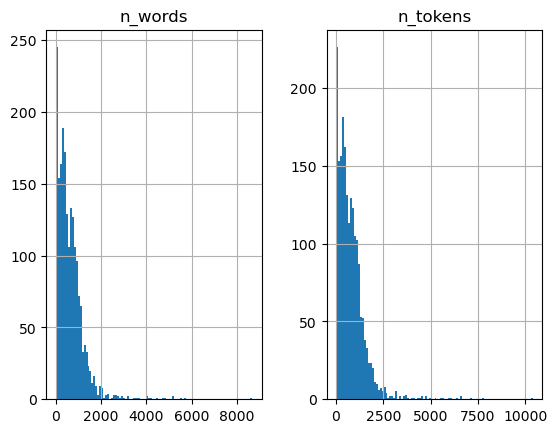

In [6]:
# a histogram of the number of words in each body and the number of tokens in each body
df.hist(column=['n_words', 'n_tokens'], bins=100)
plt.show()

In [7]:
# only keep the rows where the number of tokens is less than the token limit
df = df[df['n_tokens'] < token_limit]
# delete rows where body is empty
df = df[df['body'].notna()]

# count the number of rows in the dataframe
print('Number of rows in the dataframe: ', len(df))

# only left first 1200 rows
df = df.iloc[:1100, :]

# count the number of rows in the dataframe
print('Number of rows in the dataframe: ', len(df))

Number of rows in the dataframe:  1784
Number of rows in the dataframe:  1100


In [8]:
openai.api_key = OPENAI_API_KEY
# Base prompt for the AI
messages = [
  {
    "role": "system",
    "content": "Analyze the provided media text to identify and extract the key causal sequences."
  },
  {
    "role": "user",
    "content": "Please identify and list the essential causal chains in the news excerpt provided below. \
      Use only the terminology found in the original text.\
      Ensure that each sequence listed is a direct, sequential, and acyclic causal relationship. \
      For each cause and effect pair, use '->' to denote direction between cause and effect. \
      Your findings should be formatted as follows:\
      ######\
      1. [cause] Specific event or action -> [effect] Result or consequence\
      2. [cause] Specific event or action -> [effect] Result or consequence\
      ######\
      \
      Here's an example based on an excerpt for your guidance:\
      ######\
      Example Excerpt: \
      President Donald Trump and his family said goodbye to 2017 with a lavish New Year's Eve party at his private club in Florida. \
      'It will be a fantastic 2018,' Trump said, as he entered the gilded ballroom at Mar-a-Lago, accompanied by first lady Melania Trump and son Barron.\
      Asked for his reaction to North Korea leader Kim Jon Un's remarks about having a nuclear button on his desk, Trump responded by saying, 'We'll see.' \
      Guests at the party included senior White House advisers Ivanka Trump and Jared Kushner, Trump's sons Eric Trump and Donald Trump Jr., and Treasury Secretary Steven Mnuchin.\
        Since taking office, President Trump has made frequent visits to his for-profit properties. He has refused to divest from his real estate and hotel empire, \
         drawing criticism from ethics experts. Earlier in the day, Trump wished a happy new year to the people who elected him to the White House—and those who kept him in the headlines. \
        'As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year.\
        2018 will be a great year for America!' Trump tweeted. He followed up more than an hour later: 'HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!'\
         The president is spending the holidays in Palm Beach, where he told reporters outside, 'We are going to have a tremendous year. Stock market, I think, is going to continue to go up. \
        Companies are going to continue to come into the country.' Also Sunday, the president tweeted out a compilation video showing him meeting U.S. \
        service members, visiting flood zones in Texas and signing the GOP-backed tax overhaul package into law. Trump has called out his critics in holiday tweets before. \
        In November 2013, he posted: 'Happy Thanksgiving to all—even the haters and losers!' The president on Sunday cited his success in placing a new justice on the Supreme Court,\
        his efforts to cut regulations, and his big win on overhauling taxes. He's called for more progress in 2018, including the passage of a massive infrastructure bill,\
        although analysts say it could prove difficult given how the GOP-led Senate will hold a very slim 51-49 majority. The White House said Trump has been briefed on New Year's Eve\
        security precautions around the country and will continue to monitor those efforts. Fox News' Serafin Gomez and the Associated Press contributed to this report.\
      ######\
      Example Cause and Effect Pairs:\
      1. [cause] Trump's frequent visits to his for-profit properties -> [effect] Criticism from ethics experts\
      2. [cause] GOP-led Senate holding a slim majority -> [effect] Difficulty in passing new legislation\
      ######\
      The text excerpt is as follows: {media_text}."
  }
]

In [9]:
# Check if the output file exists, if so, load the DataFrame from it
if os.path.exists(output_file_path):
    df = pd.read_csv(output_file_path)
    print(f"Resuming from checkpoint, starting at row {df.last_valid_index() + 1}...")
else:
    # If there is no checkpoint, then add a new column to the original DataFrame for storing results
    df['GPT_causal_graph'] = None

# iterate over the DataFrame rows
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows"):
    if pd.notnull(row['GPT_causal_graph']):  # if this cell is already filled, skip to the next row
        continue

    news_text = row['body']

    # Prepare the prompt by inserting the news text into the template
    prompt = deepcopy(messages)
    prompt[1]["content"] = prompt[1]["content"].replace("{media_text}", news_text)


    try:
        # Make the API request
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=prompt
        )

        # Extract the analysis from the response
        analysis_results = response['choices'][0]['message']['content']

        # Store the analysis results back in your DataFrame
        df.at[index, 'GPT_causal_graph'] = analysis_results

    except Exception as e:
        print(f"An exception occurred: {e}")
        # Optionally, break or continue based on the type of error and your preference

    # Optional: print progress
    # print(f"Processed row {index + 1} of {len(df)}")

    # Save the DataFrame to the checkpoint file after processing each row
    df.to_csv(output_file_path, index=False)
    

Processing rows: 100%|██████████| 1100/1100 [5:50:29<00:00, 19.12s/it]  


# put data to jsonl format (for hugging face dataset)

In [10]:
import jsonlines
import json

# do 6:2:2 split
df = pd.read_csv(output_file_path)
df = df.sample(frac=1).reset_index(drop=True)
train_idx = int(len(df) * 0.6)
valid_idx = int(len(df) * 0.8)
test_idx = len(df)

train_df = df.iloc[:train_idx, :]
valid_df = df.iloc[train_idx:valid_idx, :]
test_df = df.iloc[valid_idx:, :]

#convert to jsonl
def convert_to_jsonl(df, jsonl_path):
    with jsonlines.open(jsonl_path, mode='w') as writer:
        for index, row in df.iterrows():
            writer.write(json.loads(row.to_json()))

convert_to_jsonl(train_df, '../data/synthetic_data/train.jsonl')
convert_to_jsonl(valid_df, '../data/synthetic_data/validation.jsonl')
convert_to_jsonl(test_df, '../data/synthetic_data/test.jsonl')

In [1]:
# check if it works from huggingface
from datasets import load_dataset
train_data = load_dataset('BENBENBENb/sythetic_casual_relation_medium_scale', split='train')
valid_data = load_dataset('BENBENBENb/sythetic_casual_relation_medium_scale', split='validation')
test_data = load_dataset('BENBENBENb/sythetic_casual_relation_medium_scale', split='test')
